In [2]:
#constants and imports
import requests
import sys
import json
from datetime import datetime, timezone
import csv
from ratelimit import limits, sleep_and_retry
from io import StringIO
import pandas as pd
import gc
import os
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import streamlit as st
from datetime import timedelta
import community as community_louvain
from collections import defaultdict

partitionFile = "partition.json"
graphPath = "bipartite_graph.pkl"
baseUrl = "https://api.warframe.market/v1"
itemListPath = "/items"
itemOrdersPath = "/items/{url_name}/orders"
tradableItemsAPIError = "Could not reach tradeable items API"
itemOrdersAPIError = "Could not reach item orderedKeysedKeysedKeysedKeyss API"
itemNeededData = 'url_name'
orderNeededData = ['platinum', 'order_type', 'creation_date', 'last_update','user','quantity','id']
userNeededData = ['reputation', 'ingame_name', 'platform','region','crossplay','id','last_seen']
ordersOutputPath = 'orders.csv'
usersOutputPath = 'users.csv'
apiRatePeriod = 1
apiRateCalls = 3
orderDataOrder = ['creation_date','quantity','last_update','platinum','order_type','id','user','item','data_date']
userDataOrder = ['reputation','ingame_name','last_seen','crossplay','platform','id','region','data_date']

In [3]:
def getItemUrlList():
    itemsData = requests.get(baseUrl + itemListPath)
    if(not itemsData.ok):
        sys.exit(tradableItemsAPIError)
    itemsData = json.loads(itemsData.content)['payload']['items']
    items = []
    for item in itemsData:
        del item['id']
        del item['thumb']
        del item['item_name']
        items.append(item.get(itemNeededData))
    return items





In [4]:
@sleep_and_retry
@limits(calls= apiRateCalls, period=apiRatePeriod)
def getItemOrders(item_url):
    itemOrders = requests.get(baseUrl + itemOrdersPath.format(url_name = item_url))
    if(not itemOrders.ok):
        sys.exit(itemOrdersAPIError)
    return json.loads(itemOrders.content)['payload']['orders']


def getUsersAndOrders(item_url):
    itemOrders = getItemOrders(item_url)
    users = []
    orders = []
    for order in itemOrders:
        orderKeys = list(order.keys())
        for key in orderKeys:
            if key not in orderNeededData:
                del order[key]
        user = order.get('user')
        userKeys = list(user.keys())
        for key in userKeys:
            if key not in userNeededData:
                del user[key]
        del order['user']
        order['user'] = user['id']
        order['item'] = item_url
        current_time = datetime.now(timezone.utc).isoformat(timespec='milliseconds')
        user['data_date'] = current_time
        order['data_date'] = current_time
        users.append(user)
        orders.append(order)
    return users, orders

In [5]:
def to_csv(to_csv, path, keys = None, writeheader = 1):
    if not to_csv:
        print(f"Warning: Empty data list for {path}. Skipping write.")
        return
    
    if not keys:
        keys = to_csv[0].keys()
    with open(path, 'a', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        if writeheader != 0:
            dict_writer.writeheader()
        dict_writer.writerows(to_csv)



In [6]:
def outputResults(users, orders):
    to_csv(users, usersOutputPath)
    to_csv(orders, ordersOutputPath)

In [ ]:

def addData():
    item_urls = getItemUrlList()
    count = 0
    maxCount = len(item_urls)
    for item_url in item_urls:
        users, orders = getUsersAndOrders(item_url)
        outputResults(users,orders)
        count += 1
        print( str(count) + ' out of ' + str(maxCount) + ' Data added for: ' + item_url)
    

In [8]:
def reorderCsvLines(lines, header, new_order):
    header_cols = next(csv.reader([header]))
    lines_iter = iter(lines)
    result = []
    for line in lines_iter:
        parsed = next(csv.reader([line]))
        row_dict = dict(zip(header_cols, parsed))
        reordered = {key: row_dict[key] for key in new_order}
        result.append(reordered)
    return result


In [9]:
def orderCsvFile(path, orderedKeys):

    with open(path, 'r', encoding='utf-8') as f:
        current_header = None
        current_section = []
        result = []
        for line in f:
            stripped = line.strip()
            if all(field in stripped for field in orderedKeys) and not current_header:
                current_header = stripped
            elif all(field in stripped for field in orderedKeys) and current_header:
                
                sorted = reorderCsvLines(current_section, current_header, orderedKeys)
                current_header = stripped
                current_section = []

                result += sorted
                #to_csv(sorted, outPath, orderedKeys, 0)

          
            else:
                current_section.append(stripped)
        
        
        if current_section and current_header:
            sorted = reorderCsvLines(current_section, current_header, orderedKeys)
            result += sorted
            #to_csv(sorted, outPath, orderedKeys, 0)
        
        return result
        
        





In [10]:
def order_results():
    ordered_users = orderCsvFile(usersOutputPath, userDataOrder)
    ordered_orders = orderCsvFile(ordersOutputPath, orderDataOrder)

    
    unique_users = list({frozenset(d.items()): d for d in ordered_users}.values())

    open(usersOutputPath, 'w').close()
    open(ordersOutputPath, 'w').close()

    to_csv(ordered_orders, ordersOutputPath, orderDataOrder, 1)
    to_csv(unique_users, usersOutputPath, userDataOrder, 1)

In [ ]:
def save_graph(graph, path):
    with open(path, "wb") as f:
        pickle.dump(graph, f)

def load_graph(path):
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None 

In [12]:
def build_bipartite_graph(orders, users):
    B = nx.Graph()
    user_nodes = users["id"].unique()
    item_nodes = orders["item"].unique()
    B.add_nodes_from(user_nodes, bipartite="users")
    B.add_nodes_from(item_nodes, bipartite="items")
    for _, row in orders.iterrows():
        u = row["user"]
        i = row["item"]
        attrs = {
            "order_type": row["order_type"],
            "platinum": row["platinum"],
            "quantity": row["quantity"]
        }
        B.add_edge(u, i, **attrs)
    return B

In [13]:
def remove_data_date_and_reorder(csv_path, output_path=None, header_order=None):
    df = pd.read_csv(csv_path)
    if "data_date" in df.columns:
        df = df.drop(columns=["data_date"])
    if header_order:
        cols_in_df = [col for col in header_order if col in df.columns]
        df = df[cols_in_df]
    df.to_csv(output_path or csv_path, index=False)


def clean_user_csv(csv_path, output_path=None, header_order=None):
    df = pd.read_csv(csv_path)
    df = df.drop(columns=["data_date"], errors="ignore")

    if "id" in df.columns:
        df = df.drop_duplicates(subset="id", keep="last")

    if header_order:
        df = df[[col for col in header_order if col in df.columns]]

    df.to_csv(output_path or csv_path, index=False)


In [14]:
@st.cache_data
def load_listings(path):
    return pd.read_csv(path) 

@st.cache_data
def load_users(path):
    return pd.read_csv(path) 



2025-06-04 20:36:48.931 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-04 20:36:48.934 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [15]:
def compute_basic_metrics(G):
    n = G.number_of_nodes()
    e = G.number_of_edges()
    users = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "users"]
    items = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "items"]
    avg_user_deg = sum(dict(G.degree(users)).values()) / len(users) if users else 0
    avg_item_deg = sum(dict(G.degree(items)).values()) / len(items) if items else 0
    dens = nx.density(G)
    return {
        "num_nodes": n,
        "num_edges": e,
        "average_user_degree": avg_user_deg,
        "average_item_degree": avg_item_deg,
        "density": dens
    }

In [16]:
def median_of_n_smallest(df, n):
    return df.nsmallest(n, "platinum")["platinum"].median()

def median_of_n_largest(df, n):
    return df.nlargest(n, "platinum")["platinum"].median()

In [ ]:
def plot_degree_distribution(G):
    users = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "users"]
    items = [n for n, d in G.nodes(data=True) if d.get("bipartite") == "items"]

    user_degs = [G.degree(n) for n in users]
    item_degs = [G.degree(n) for n in items]

    bins = 50

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    ax1.hist(user_degs, bins=bins, edgecolor="black")
    ax1.set_yscale("log")
    ax1.set_title("User Degree Distribution (Log Frequency)")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")

    ax2.hist(item_degs, bins=bins, edgecolor="black")
    ax2.set_title("Item Degree Distribution")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Frequency")

    fig.tight_layout()
    return fig



def detect_communities(graph):
    partition = community_louvain.best_partition(graph)
    return partition

def save_partition(partition, filepath):
    with open(filepath, "w",encoding='utf-8') as f:
        json.dump(partition, f)

def load_partition(filepath):
    if os.path.exists(filepath):
        with open(filepath, "r",encoding='utf-8') as f:
            return json.load(f)
    return None

def partition_to_tables(graph, partition, user_nodes, item_nodes, users_df):
    user_id_to_username = dict(zip(users_df["id"], users_df["ingame_name"]))
    user_data = []
    item_data = []
    for node, community in partition.items():
        if node in user_nodes:
            username = user_id_to_username.get(node, node)
            user_data.append({"ingame_name": username, "community": community})
        elif node in item_nodes:
            item_data.append({"item": graph.nodes[node].get("item", node), "community": community})
    user_df = pd.DataFrame(user_data)
    item_df = pd.DataFrame(item_data)
    return user_df, item_df

def count_comunities(user_df, item_df):
    user_counts = user_df.groupby("community").size().reset_index(name="user_count")
    item_counts = item_df.groupby("community").size().reset_index(name="item_count")
    summary_df = pd.merge(user_counts, item_counts, on="community", how="outer").fillna(0)
    summary_df["user_count"] = summary_df["user_count"].astype(int)
    summary_df["item_count"] = summary_df["item_count"].astype(int)
    summary_df = summary_df.sort_values("community").reset_index(drop=True)
    return summary_df


In [ ]:
redo = False
if not os.path.exists(usersOutputPath) or not os.path.exists(ordersOutputPath):
    redo = True
    addData()
    order_results() #correct the fact we have duped users and multiple headers
    remove_data_date_and_reorder(usersOutputPath,usersOutputPath,userDataOrder)
    clean_user_csv(usersOutputPath, usersOutputPath,userDataOrder)

In [ ]:
st.title("Warframe Market Analysis")
listings_df = load_listings(ordersOutputPath)
users_df = load_users(usersOutputPath)

B = load_graph(graphPath)
if B is None or redo:
    B = build_bipartite_graph(listings_df, users_df)
    save_graph(B, graphPath)


2025-06-04 14:13:03.696 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:03.755 
  command:

    streamlit run /home/silver/miniconda3/envs/testing/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-04 14:13:03.756 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:03.758 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:03.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:03.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:03.762 No runtime found, using MemoryCacheStorageManager
2025-06-04 14:13:04.266 Thread 'Thread-25': missing ScriptRunContext! This wa

2025-06-04 14:13:08.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:08.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:08.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:08.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:08.339 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:08.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:09.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:09.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

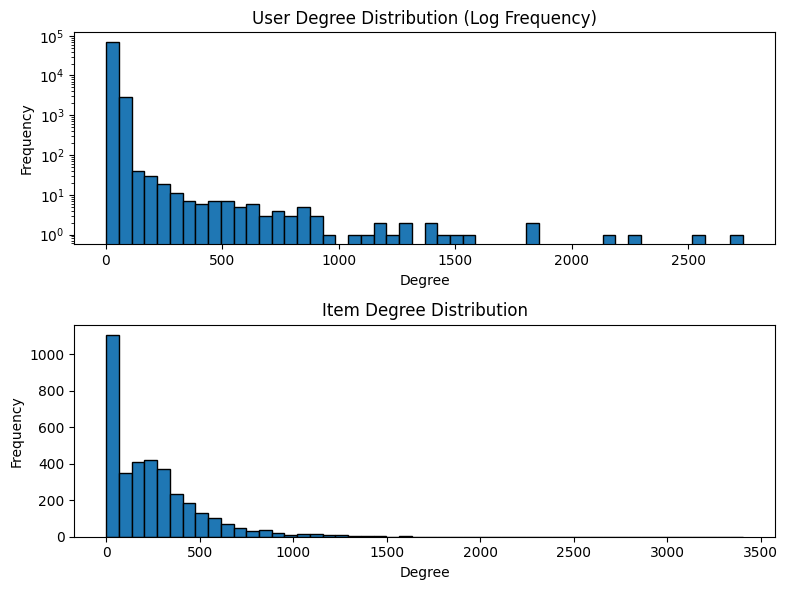

In [ ]:
metrics = compute_basic_metrics(B)
st.subheader("Basic Metrics")
st.write(metrics)

st.subheader("Degree Distribution")
fig = plot_degree_distribution(B)
st.pyplot(fig)

In [ ]:
centrality = nx.degree_centrality(B)
user_nodes = set(users_df["id"])
item_nodes = set(listings_df["item"])

user_cent = {n: c for n, c in centrality.items() if n in user_nodes}
item_cent = {n: c for n, c in centrality.items() if n in item_nodes}

users_df = users_df.copy()
users_df["last_seen"] = pd.to_datetime(users_df["last_seen"], utc=True)
current_time = datetime.now(timezone.utc)
users_df["days_since_last_login"] = (current_time - users_df["last_seen"]).dt.days

listings_df["platinum"] = listings_df["platinum"].astype(float)
listings_df["quantity"] = listings_df["quantity"].astype(int)
listings_df["value"] = listings_df["platinum"] * listings_df["quantity"]

buy_orders = listings_df[listings_df["order_type"] == "buy"]
sell_orders = listings_df[listings_df["order_type"] == "sell"]

inbound = buy_orders.groupby("user")["value"].sum().rename("inbound_plat")
outbound = sell_orders.groupby("user")["value"].sum().rename("outbound_plat")

plat_summary = pd.concat([inbound, outbound], axis=1).fillna(0)
plat_summary["total_plat"] = plat_summary["inbound_plat"] - plat_summary["outbound_plat"]

buy_order_counts = buy_orders.groupby("user").size().rename("buy_orders_count")
sell_order_counts = sell_orders.groupby("user").size().rename("sell_orders_count")

df_users = pd.DataFrame(user_cent.items(), columns=["user_id", "centrality"]) \
    .merge(users_df[["id", "ingame_name", "reputation", "days_since_last_login"]],
left_on="user_id", right_on="id", how="left") \
    .merge(plat_summary, left_on="user_id", right_index=True, how="left") \
    .merge(buy_order_counts, left_on="user_id", right_index=True, how="left") \
    .merge(sell_order_counts, left_on="user_id", right_index=True, how="left") \
    .fillna(0)

df_users = df_users.drop(columns=["user_id", "id"])

st.subheader("Users")
reputation_range = st.slider(
    "Reputation",
    int(df_users["reputation"].min()),
    int(df_users["reputation"].max()),
    (0, int(df_users["reputation"].max()))
)
inbound_range = st.slider(
    "Inbound plat",
    float(df_users["inbound_plat"].min()),
    float(df_users["inbound_plat"].max()),
    (0.0, float(df_users["inbound_plat"].max()))
)
outbound_range = st.slider(
    "Outbound plat",
    float(df_users["outbound_plat"].min()),
    float(df_users["outbound_plat"].max()),
    (0.0, float(df_users["outbound_plat"].max()))
)
total_plat_range = st.slider(
    "Total plat",
    float(df_users["total_plat"].min()),
    float(df_users["total_plat"].max()),
    (float(df_users["total_plat"].min()), float(df_users["total_plat"].max()))
)
days_since_login_range = st.slider(
    "Days since last login",
    int(df_users["days_since_last_login"].min()),
    int(df_users["days_since_last_login"].max()),
    (0, int(df_users["days_since_last_login"].max()))
)

sell_order_range = st.slider(
    "Sell order count",
    int(df_users["sell_orders_count"].min()),
    int(df_users["sell_orders_count"].max()),
    (int(df_users["sell_orders_count"].min()), int(df_users["sell_orders_count"].max()))
)

buy_order_range = st.slider(
    "Buy order count",
    int(df_users["buy_orders_count"].min()),
    int(df_users["buy_orders_count"].max()),
    (int(df_users["buy_orders_count"].min()), int(df_users["buy_orders_count"].max()))
)

filtered_df = df_users[
    (df_users["reputation"].between(*reputation_range)) &
    (df_users["inbound_plat"].between(*inbound_range)) &
    (df_users["outbound_plat"].between(*outbound_range)) &
    (df_users["total_plat"].between(*total_plat_range)) &
    (df_users["days_since_last_login"].between(*days_since_login_range)) &
    (df_users["sell_orders_count"].between(*sell_order_range)) &
    (df_users["buy_orders_count"].between(*buy_order_range))
]

st.dataframe(filtered_df, use_container_width=True)


seven_days_ago = current_time - timedelta(days=7)

active_users = users_df[pd.to_datetime(users_df["last_seen"], utc=True) >= seven_days_ago]["id"]
active_orders = listings_df[listings_df["user"].isin(active_users)]

median_platinum_sell = (
    active_orders[active_orders["order_type"] == "sell"]
    .groupby("item")
    .apply(lambda x: median_of_n_smallest(x, 5))
)

median_platinum_buy = (
    active_orders[active_orders["order_type"] == "buy"]
    .groupby("item")
    .apply(lambda x: median_of_n_largest(x, 5))
)

sell_stats = (
    active_orders[active_orders["order_type"] == "sell"]
    .groupby("item")
    .size()
    .rename("total_sell_orders")
    .to_frame()
    .join(median_platinum_sell.rename("median_platinum_sell"), how="left")
)

buy_stats = (
    active_orders[active_orders["order_type"] == "buy"]
    .groupby("item")
    .size()
    .rename("total_buy_orders")
    .to_frame()
    .join(median_platinum_buy.rename("median_platinum_buy"), how="left")
)

buy_stats = buy_orders.groupby("item")["platinum"].median().rename("median_platinum_buy").to_frame()
buy_stats["total_buy_orders"] = buy_orders.groupby("item").size()

df_items = pd.DataFrame(item_cent.items(), columns=["item_name", "centrality"]) \
    .merge(sell_stats, left_on="item_name", right_index=True, how="left") \
    .merge(buy_stats, left_on="item_name", right_index=True, how="left") \
    .fillna(0)

df_items["desirability"] = df_items["median_platinum_buy"] * df_items["total_buy_orders"]
st.subheader("Items")

mean_plat_sell_range = st.slider(
    "Median platinum sell",
    float(df_items["median_platinum_sell"].min()),
    float(df_items["median_platinum_sell"].max()),
    (float(df_items["median_platinum_sell"].min()), float(df_items["median_platinum_sell"].max()))
)

total_sell_orders_range = st.slider(
    "Total sell orders",
    int(df_items["total_sell_orders"].min()),
    int(df_items["total_sell_orders"].max()),
    (int(df_items["total_sell_orders"].min()), int(df_items["total_sell_orders"].max()))
)

mean_plat_buy_range = st.slider(
    "Median platinum buy",
    float(df_items["median_platinum_buy"].min()),
    float(df_items["median_platinum_buy"].max()),
    (float(df_items["median_platinum_buy"].min()), float(df_items["median_platinum_buy"].max()))
)

total_buy_orders_range = st.slider(
    "Total buy orders",
    int(df_items["total_buy_orders"].min()),
    int(df_items["total_buy_orders"].max()),
    (int(df_items["total_buy_orders"].min()), int(df_items["total_buy_orders"].max()))
)

desirability_range = st.slider(
    "Desirability",
    float(df_items["desirability"].min()),
    float(df_items["desirability"].max()),
    (float(df_items["desirability"].min()), float(df_items["desirability"].max()))
)

filtered_items_df = df_items[
    (df_items["desirability"].between(*desirability_range)) &
    (df_items["median_platinum_sell"].between(*mean_plat_sell_range)) &
    (df_items["total_sell_orders"].between(*total_sell_orders_range)) &
    (df_items["median_platinum_buy"].between(*mean_plat_buy_range)) &
    (df_items["total_buy_orders"].between(*total_buy_orders_range))
]



st.dataframe(
    filtered_items_df[[
        "item_name",
        "centrality",
        "median_platinum_sell",
        "total_sell_orders",
        "median_platinum_buy",
        "total_buy_orders",
        "desirability"
    ]],
    use_container_width=True
)


2025-06-04 14:13:10.532 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:10.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:10.534 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:10.535 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:10.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:10.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:10.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:10.539 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [ ]:
st.subheader("Search User")
search_user = st.text_input("Enter In-Game Name").strip().lower()

if search_user:
    user_info = df_users[df_users["ingame_name"].str.lower() == search_user]
    if not user_info.empty:
        st.write("User Details")
        st.dataframe(user_info, use_container_width=True)

        user_id = users_df[users_df["ingame_name"].str.lower() == search_user]["id"].values[0]
        user_orders = listings_df[listings_df["user"] == user_id].copy()
        user_orders["value"] = user_orders["platinum"] * user_orders["quantity"]

        user_buy_orders = user_orders[user_orders["order_type"] == "buy"][
            ["item", "quantity", "platinum", "value"]
        ]
        user_sell_orders = user_orders[user_orders["order_type"] == "sell"][
            ["item", "quantity", "platinum", "value"]
        ]

        st.write("Buy Orders")
        st.dataframe(user_buy_orders, use_container_width=True)

        st.write("Sell Orders")
        st.dataframe(user_sell_orders, use_container_width=True)
    else:
        st.write("User not found")




2025-06-04 14:13:14.740 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.741 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.744 Session state does not function when running a script without `streamlit run`
2025-06-04 14:13:14.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.747 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
st.subheader("Search Item")
search_item = st.text_input("Enter Item Name").strip().lower()

if search_item:
    matched_items = df_items[df_items["item_name"].str.lower().str.contains(search_item)]
    if not matched_items.empty:
        st.write("Item Details")
        st.dataframe(matched_items, use_container_width=True)

        item_name = matched_items["item_name"].values[0]
        item_orders = listings_df[listings_df["item"] == item_name].copy()
        item_orders["value"] = item_orders["platinum"] * item_orders["quantity"]

        user_map = users_df.set_index("id")["ingame_name"].to_dict()
        item_orders["username"] = item_orders["user"].map(user_map)

        item_buy_orders = item_orders[item_orders["order_type"] == "buy"][
            ["username", "quantity", "platinum", "value"]
        ]
        item_sell_orders = item_orders[item_orders["order_type"] == "sell"][
            ["username", "quantity", "platinum", "value"]
        ]

        st.write("Buy Orders")
        st.dataframe(item_buy_orders, use_container_width=True)

        st.write("Sell Orders")
        st.dataframe(item_sell_orders, use_container_width=True)
    else:
        st.write("Item not found")

2025-06-04 14:13:14.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 14:13:14.768 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
partition = load_partition(partitionFile)
if partition is None or redo:
    partition = detect_communities(B)
    save_partition(partition, partitionFile)
user_df, item_df = partition_to_tables(B, partition, user_nodes, item_nodes, users_df)

st.subheader("Comunities")
st.dataframe(user_df, use_container_width=True)
st.dataframe(item_df, use_container_width=True)

counts_df = count_comunities(user_df, item_df)
st.dataframe(counts_df)